# Qiskit Pulse Tutorial: Excited State Promoted Readout

### Helena Zhang, Software Developer, IBM Quantum (Helena.Zhang@ibm.com)

![qv64.png](qv64.png)

To achieve a quantum volume of 64 ([arxiv.org/abs/2008.08571](https://arxiv.org/abs/2008.08571)), the IBM Quantum team employed a host of techniques, including **excited state promoted readout** using Qiskit Pulse. Let's do a hands-on demo of this technique!

In excited state promoted readout, we take advantage of higher excited states of the transmon by exciting the $|1\rangle$ state to $|2\rangle$ and measure in the $|0\rangle$, $|2\rangle$ subspace. This can improve measurement fidelity since the $|2\rangle \rightarrow |0\rangle$ two-photon transition is highly suppressed.

![readout.png](readout.png)


# Goal and Outline

Due to various noise processes, qubit parameters drift around over time. Therefore, experimentalists always calibrate their pulses prior to starting the experiment. Classical measurement data coming out of a superconducting qubit circuit after applying an appropriate kernel is in the form of I-Q data. In this tutorial, we will be coding calibration and measurement experiments in order to classify I-Q data into $|0\rangle$ and $|1\rangle$ states. 

1. Calibrate the frequencies of $|0\rangle \rightarrow |1\rangle$ and $|1\rangle \rightarrow |2\rangle$ transitions using a frequency spectroscopy Pulse experiment.
2. Calibrate the $|0\rangle \rightarrow |1\rangle$ and $|1\rangle \rightarrow |2\rangle$ $\pi$-pulses using a Rabi Pulse experiment.
3. Do a discriminator experiment to get $|0\rangle$, $|1\rangle$, and $|2\rangle$ I-Q data.
4. Use machine learning classifiers to discriminate between the states.
5. Quantify whether excited state promoted readout improves readout performance.

# 0. Set up libraries and backend

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import IBMQ

if not IBMQ.active_account():
    IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-community', group='reservations', project='main')
backend = provider.get_backend('ibmq_rome')

## Get backend defaults

In [ ]:
backend_config = backend.configuration()
backend_defaults = backend.defaults()
assert backend_config.open_pulse, "Backend doesn't support Pulse"

qubit = 0
dt = backend_config.dt
GHz = 1e9
MHz = 1e6
us = 1e-6

# get last calibrated qubit frequency
qubit_01_freq_default = backend_defaults.qubit_freq_est[qubit]
print(f"Qubit 0, 0->1 state estimated frequency: {qubit_01_freq_default/GHz} GHz")

Qubit 0, 0->1 state estimated frequency: 4.9686519611847055 GHz


<a id="sec1"></a>
## 1. Frequency spectroscopy

Let's calibrate $|0\rangle \rightarrow |1\rangle$ and $|1\rangle \rightarrow |2\rangle$ frequencies. For $|0\rangle \rightarrow |1\rangle$, we will use the last calibrated value as a starting point. For $|1\rangle \rightarrow |2\rangle$, we know where it is relatively based on past experiences.

To probe these transitions, we will drive a Gaussian pulse between our start and ending states and vary its frequency. If we are not on resonance, we expect there will be no excitation, and vice versa. We expect to get an output plot that shows where our transition frequencies are.

Let's look at the Qiskit documentation ([qiskit.org/documentation](https://qiskit.org/documentation)) for how to write a Gaussian pulse:

![gaussian_doc.png](gaussian_doc.png)



## Construct basic $|0\rangle \rightarrow |1\rangle$ pulse

In [ ]:
import qiskit.pulse as pulse
from qiskit.pulse.library import gaussian

def round_16(num):
    return int(num) - int(num)%16

drive_samples_us = 0.1
drive_samples = round_16(drive_samples_us*us/dt)
drive_sigma = round_16(drive_samples_us/4*us/dt)
drive_power = 0.2

# Start constructing freq_sweep_pulse

# End constructing

## Construct $|0\rangle \rightarrow |1\rangle$ pulse schedule

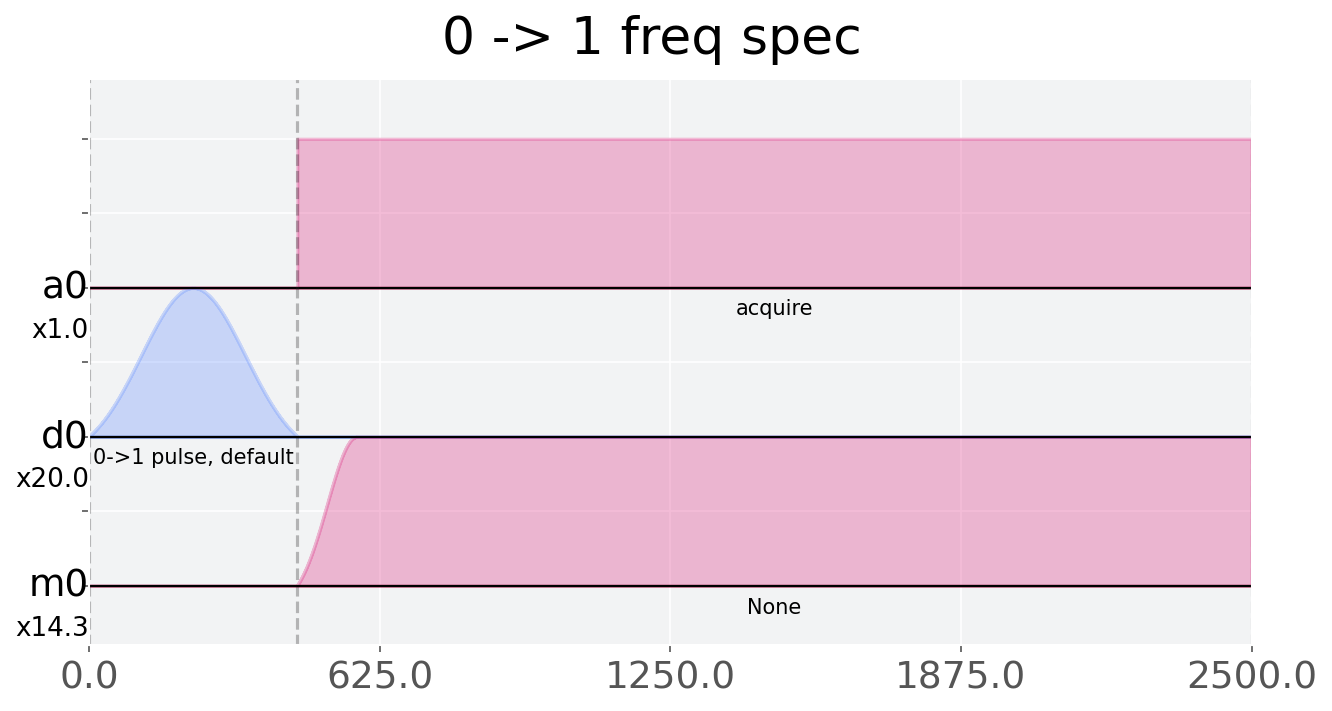

In [ ]:
drive_chan = pulse.DriveChannel(qubit)
meas_chan = pulse.MeasureChannel(qubit)
acq_chan = pulse.AcquireChannel(qubit)
from qiskit.scheduler import measure

# Start constructing sched_01

# End constructing

# Visualize sched_01
from qiskit.visualization import SchedStyle
plot_options={"plot_range": [0,2500],
              "channels": [drive_chan,meas_chan,acq_chan],
              "label": True,
              "style": SchedStyle(figsize=(10,5))}
sched_01.draw(**plot_options)

## Assemble program and run

In [ ]:
from qiskit import assemble
freq_range = np.linspace(-30*MHz+qubit_01_freq_default, 30*MHz+qubit_01_freq_default, 50)

freq_sweep_program = assemble(sched_01,
                              backend=backend,
                              meas_level=1,
                              meas_return='avg',
                              shots=256,
                              schedule_los=[{drive_chan: freq} for freq in freq_range]
                             )

freq_sweep_job = backend.run(freq_sweep_program)
freq_sweep_job.update_name("frequency sweep 0->1")

from qiskit.tools.monitor import job_monitor
job_monitor(freq_sweep_job)

Job Status: job has successfully run


# Look at our data

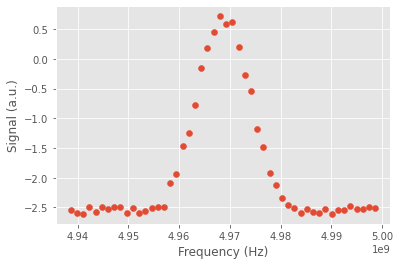

In [ ]:
result = freq_sweep_job.result()

scale_factor = 1e-7
data = [result.get_memory(i)[0]*scale_factor for i in range(len(result.results))]

plt.scatter(freq_range,data)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Signal (a.u.)")
plt.show()

### Fit our data

Fit parameters: [ 6.72506131e+07  4.96871658e+09  5.73446659e+06 -2.83465141e+00]


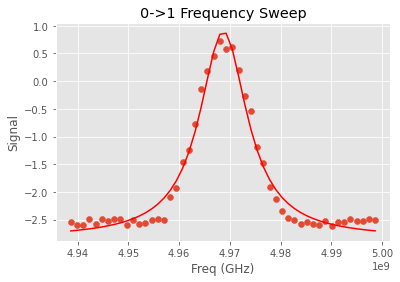

In [ ]:
from scipy.optimize import curve_fit

lorentzian = lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C
freq_sweep_fitparams, _ = curve_fit(lorentzian, freq_range, data, [6e7, qubit_01_freq_default, 4e6, -3])
y_fit = lorentzian(freq_range, *freq_sweep_fitparams)
print(f"Fit parameters: {freq_sweep_fitparams}")
plt.scatter(freq_range,data)
plt.plot(freq_range, y_fit, color='red')
plt.title("0->1 Frequency Sweep")
plt.xlabel("Freq (GHz)")
plt.ylabel("Signal")
plt.show()

## Finish calibration

In [ ]:
qubit_01_freq_cal = freq_sweep_fitparams[1]
print(f"Updated qubit frequency from {qubit_01_freq_default/GHz} to {qubit_01_freq_cal/GHz} GHz")

Updated qubit frequency from 4.9686519611847055 to 4.96871658457914 GHz


## $|1\rangle \rightarrow |2\rangle$ spectroscopy

To excite the $|1\rangle \rightarrow |2\rangle$ transition, we first excite the $|1\rangle$ state by applying the previously calibrated $|0\rangle \rightarrow |1\rangle$ $\pi$ pulse. We then perform the frequency sweep over excitations of the $|1\rangle$ state. A peak should be observed at a frequency lower than the $0\rightarrow1$ frequency that corresponds to the $|1\rangle \rightarrow |2\rangle$ frequency.

To drive the $1\rightarrow 2$ $\pi$ transition, we set the local oscillator (LO) frequency to `qubit_01_freq_cal` and multiply a sine function onto the $|1\rangle \rightarrow |2\rangle$ pulse at `freq-qubit_01_freq_cal` to add a modulation at `freq`, the desired scan frequency. Applying the sinusoidal sideband, as it's known, enables us to change the LO frequency without manually setting it when assembling the program.

![signal_mixing.png](signal_mixing.png)

### Write modulation function

In [ ]:
from qiskit.pulse import Waveform

def apply_sideband(pulse, mod_freq, carrier_freq, duration):
    # Start code to return modulated pulse

    # End code

### Construct $|1\rangle \rightarrow |2\rangle$ pulse schedule

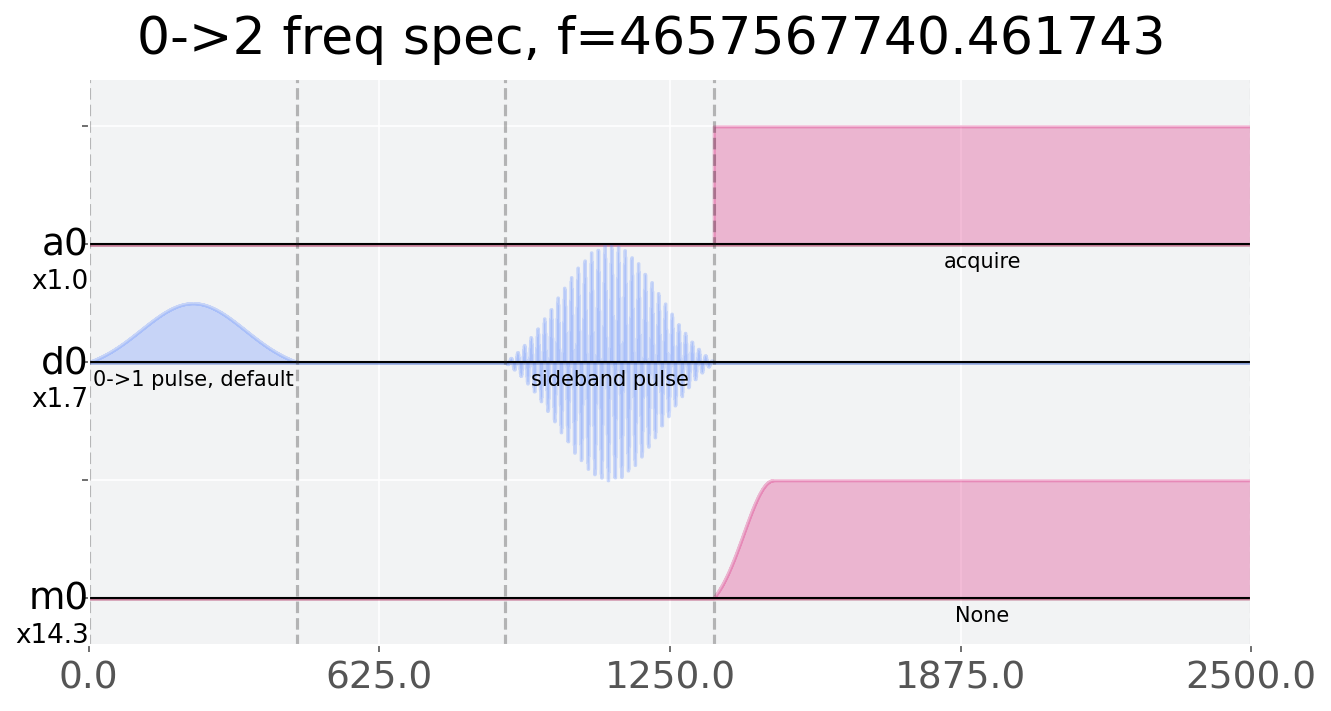

In [ ]:
freq_offset = 342*MHz # for Rome
excited_sweep_freqs = qubit_01_freq_cal - freq_offset + np.linspace(-30e6, 30e6, 50)
sched_12 = []

freq_sweep_pulse_bigger = gaussian(
    duration=drive_samples,
    amp=0.6,
    sigma=drive_sigma,
    name="0->1 pulse, default")

for freq in excited_sweep_freqs:
    freq_sweep_12_pulse = apply_sideband(freq_sweep_pulse_bigger, freq, qubit_01_freq_cal, drive_samples)

    # Start constructing single frequency schedule using pulses we already have

    # End constructing
    
    sched_12.append(sched)

sched.draw(**plot_options)

### Assemble and run program

In [ ]:
excited_freq_sweep_program = assemble(sched_12,
                                      backend=backend, 
                                      meas_level=1,
                                      meas_return='avg',
                                      shots=512,
                                      schedule_los=[{drive_chan: qubit_01_freq_cal}]
                                                     * len(excited_sweep_freqs))

excited_freq_sweep_job = backend.run(excited_freq_sweep_program)
excited_freq_sweep_job.update_name("frequency sweep 1->2")
job_monitor(excited_freq_sweep_job)

Job Status: job has successfully run


### Plot and fit results

Fit parameters: [-6.52632032e+07  4.62964366e+09  1.76561065e+07  3.99630901e+00]


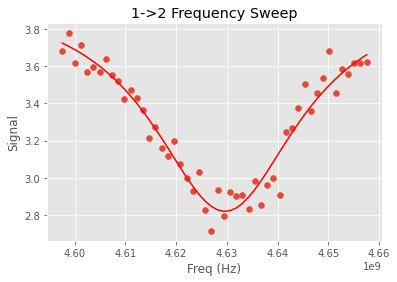

In [ ]:
result = excited_freq_sweep_job.result()
excited_freq_sweep_data = [result.get_memory(i)[0]*scale_factor for i in range(len(result.results))]

fitparams, _ = curve_fit(lorentzian,
                         excited_sweep_freqs,
                         excited_freq_sweep_data,
                         [1e7, qubit_01_freq_cal - freq_offset, 1e6, 31])
print(f"Fit parameters: {fitparams}")

y_fit = lorentzian(excited_sweep_freqs, *fitparams)

plt.scatter(excited_sweep_freqs,excited_freq_sweep_data)
plt.plot(excited_sweep_freqs, y_fit, color='red')

plt.title("1->2 Frequency Sweep")
plt.xlabel("Freq (Hz)")
plt.ylabel("Signal")
plt.show()

### Update frequency

In [ ]:
qubit_12_freq = fitparams[1]

print(f"Updated 1->2 freq to {qubit_12_freq}.")

Updated 1->2 freq to 4629643663.958706.


# 2. Rabi Calibration Experiment
## 2.1 $|0\rangle \rightarrow |1\rangle$ Rabi Experiment

Next, we perform a Rabi experiment to compute the $0\rightarrow1 ~ \pi$ pulse amplitude and obtain a fully calibrated $\pi$ pulse. Recall that a $\pi$ pulse is a pulse that takes us from the $|0\rangle$ to $|1\rangle$ state (a $\pi$ rotation on the Bloch sphere). We will sweep over different drive amplitudes to find the pulse drive amplitude that corresponds to maximal population inversion to the $|1\rangle$ state.

## Define sweep range

In [ ]:
num_rabi_points = 50
rabi_01_drive_amps = np.linspace(0, 0.3, num_rabi_points)

## Construct pulse schedule

We can construct the schedule ourselves, or use the built-in `rabi_schedules` method in Ignis.

![rabi_schedules.png](rabi_schedules.png)

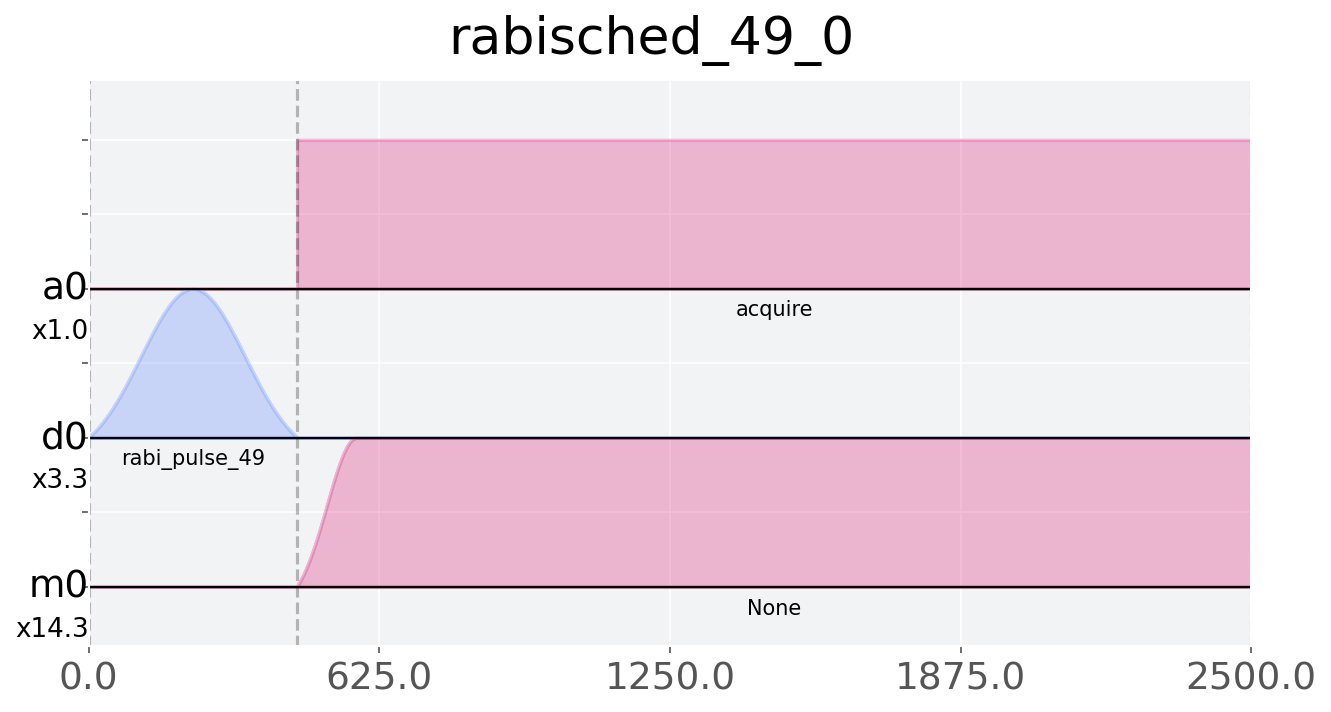

In [ ]:
from qiskit.ignis.characterization.calibrations import rabi_schedules, RabiFitter

rabi_schedules, xdata = rabi_schedules(amp_list=rabi_01_drive_amps, 
                                       qubits=[qubit], 
                                       pulse_width=drive_samples, 
                                       pulse_sigma=drive_sigma,
                                       drives=[drive_chan], 
                                       inst_map=backend.defaults().instruction_schedule_map, 
                                       meas_map=backend.configuration().meas_map)
from qiskit.visualization import SchedStyle
rabi_schedules[-1].draw(**plot_options)

## Assemble program and run

In [ ]:
rabi_program = assemble(rabi_schedules,
                        backend=backend,
                        meas_level=1,
                        meas_return='avg',
                        shots=256,
                        schedule_los=[{drive_chan: qubit_01_freq_cal}]*num_rabi_points
                        )
rabi_01_job = backend.run(rabi_program)
rabi_01_job.update_name("rabi 0->1 calibration")
job_monitor(rabi_01_job)

Job Status: job has successfully run


Q: what is wrong with this Rabi scan?
    ![badrabi.png](badrabi.png)

## Fit data

We can first fit the $|0\rangle \rightarrow |1\rangle$ Rabi data using the built-in `RabiFitter` in Ignis.

fit parameters: {'0': [array([-1.61740432e+07,  9.31055771e+00,  2.83296824e-02, -7.44092717e+05])]}
pi-amplitude: 0.05370247579207625


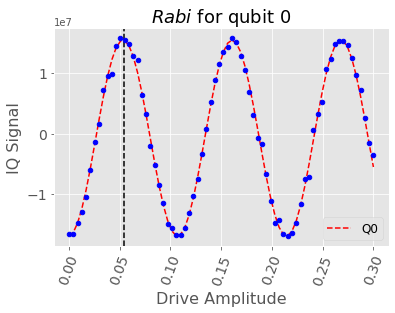

In [ ]:
result = rabi_01_job.result()
rabi_fit = RabiFitter(result, rabi_01_drive_amps, [0], fit_p0 = [-2e7, 10, -0.1, -0.02]) # amp, freq, phase, offset
rabi_fit.plot(0)
print(f"fit parameters: {rabi_fit.params}")
print(f"pi-amplitude: {rabi_fit.pi_amplitude(0)}")

## Define calibrated $\pi$ pulse

In [ ]:
pi_amp_01 = rabi_fit.pi_amplitude(0)
pi_pulse_01 = pulse.Gaussian(duration=drive_samples,
                             amp=pi_amp_01, 
                             sigma=drive_sigma,
                             name='pi_pulse_01 calibrated')
print(f"Calibrated 0->1 pi pulse amplitude: {pi_amp_01}")

Calibrated pi pulse has amplitude 0.05323766492668955


## 2.2 $|1\rangle \rightarrow |2\rangle$ Rabi Experiment

We will now calibrate the Rabi experiment using what we've learned from the Rabi and frequency scan experiments. We apply a $0\rightarrow1$ $\pi$ pulse and then sweep over drive amplitudes at the $1\rightarrow2$ frequency (using the sideband method).

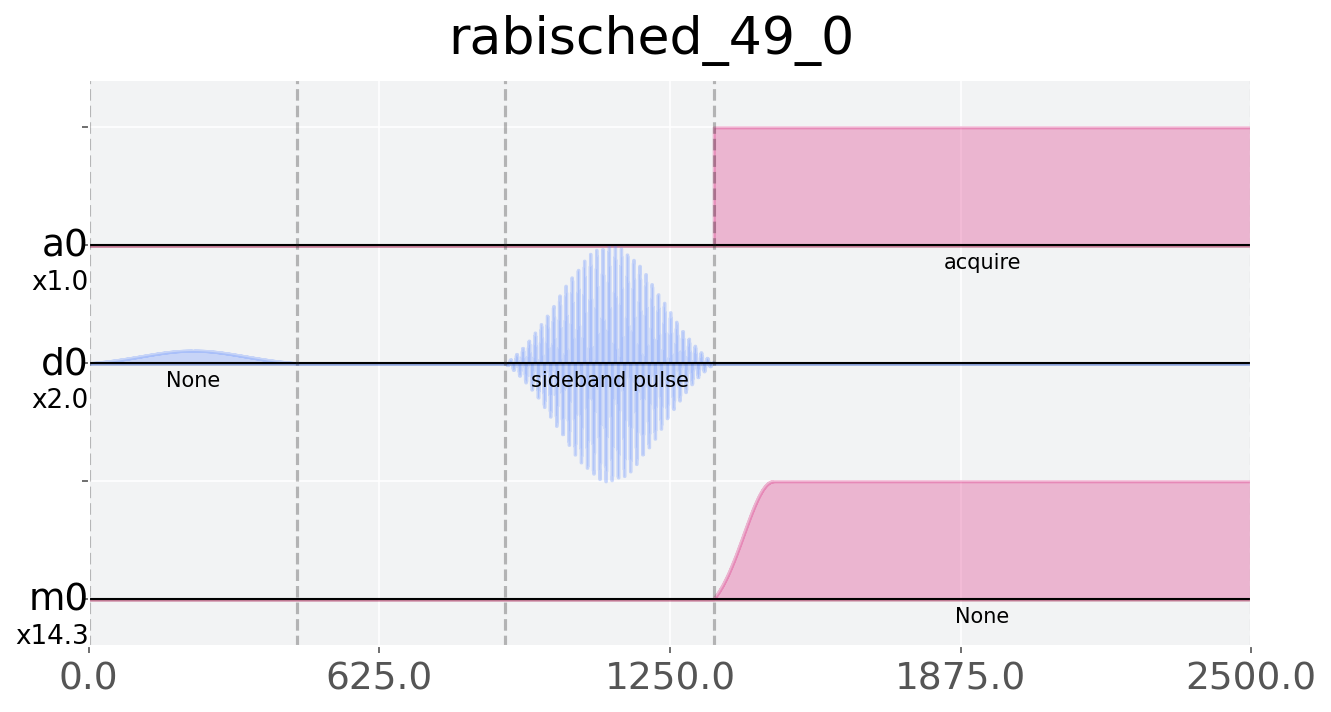

In [ ]:
num_rabi_points = 50
drive_amp_min = 0
drive_amp_max = 0.5
drive_amps = np.linspace(drive_amp_min, drive_amp_max, num_rabi_points)

# Pulse length factor
len_factor = 1

rabi_12_schedules = []
for ii, drive_amp in enumerate(drive_amps):
    base_12_pulse = gaussian(duration=round_16(drive_samples*len_factor),
                               sigma=round_16(drive_sigma*len_factor),
                               amp=drive_amp,
                               name='base_12_pulse')

    # Start constructing rabi_12_pulse and schedule using it

    # End construction
    
    rabi_12_schedules.append(schedule)
rabi_12_schedules[-1].draw(**plot_options)

### Assemble and run

In [ ]:
rabi_12_expt_program = assemble(rabi_12_schedules,
                                backend=backend,
                                meas_level=1,
                                meas_return='avg',
                                shots=256,
                                schedule_los=[{drive_chan: qubit_01_freq_cal}]
                                               * num_rabi_points)

rabi_12_job = backend.run(rabi_12_expt_program)
rabi_12_job.update_name("rabi 1->2")
job_monitor(rabi_12_job)

### Fit results

{'0': [array([1.02444382e+07, 5.80504964e+00, 3.81393722e-02, 1.27974404e+05])]}
0.08613190766532365


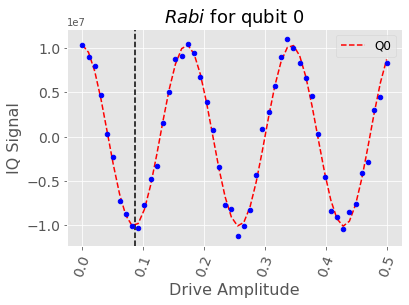

In [ ]:
result = rabi_12_job.result()
rabi_12_fit = RabiFitter(result, drive_amps, [0], fit_p0 = [1/scale_factor, 6, 0.1, 0])
rabi_12_fit.plot(0)
print(rabi_12_fit.params)
print(rabi_12_fit.pi_amplitude(0))

## Make calibrated pulse


In [ ]:
print(f"Calibrated 1->2 pi amplitude: {rabi_12_fit.pi_amplitude(0)}")
pi_pulse_12 = gaussian(duration=drive_samples*len_factor,
                                 amp=rabi_12_fit.pi_amplitude(0), 
                                 sigma=drive_sigma*len_factor,
                                 name='pi_pulse_12')
# make sure this pulse is sidebanded
pi_pulse_12 = apply_sideband(pi_pulse_12, qubit_12_freq, qubit_01_freq_cal, drive_samples*len_factor)

Calibrated 1->2 pi amplitude: 0.08613190766532365


## 3. Tri-state discrimination experiment

We now have all the pieces for our excited state promoted readout experiment. To do so, we need to gather I-Q data for $|0\rangle$, $|1\rangle$, and $|2\rangle$ states. To achieve this, we will create three separate schedules: one which simple measures in the ground state, one which uses our calibrated $\pi$-pulse to get to the $|1\rangle$ state and then measure, and one which excites the $|1\rangle$ state to the $|2\rangle$ using our sideband pulse.

In [ ]:
zero_schedule = pulse.Schedule(name="cal_0")
# Start |0> schedule

# End |0> schedule

one_schedule = pulse.Schedule(name="cal_1")
# Start |1> schedule

# End |1> schedule

two_schedule = pulse.Schedule(name="cal_2")
# Start |2> schedule

# End |2> schedule

## Assemble and run the program

In [ ]:
IQ_012_program = assemble([zero_schedule, one_schedule, two_schedule],
                           backend=backend,
                           meas_level=1,
                           meas_return='single',
                           shots=1024,
                           schedule_los=[{drive_chan: qubit_01_freq_cal}] * 3)

IQ_012_job = backend.run(IQ_012_program)
job_monitor(IQ_012_job)

Job Status: job has successfully run


## Process the result and plot

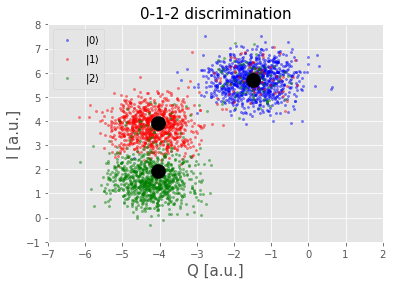

In [ ]:
result = IQ_012_job.result()

# Start getting IQ_012_data from result

# End getting IQ_012_data

zero_data = IQ_012_data[0]
one_data = IQ_012_data[1]
two_data = IQ_012_data[2]

def IQ_012_plot(x_min, x_max, y_min, y_max):
    plt.scatter(np.real(zero_data), np.imag(zero_data), 
                    s=5, cmap='viridis', c='blue', alpha=0.5, label=r'$|0\rangle$')
    plt.scatter(np.real(one_data), np.imag(one_data), 
                    s=5, cmap='viridis', c='red', alpha=0.5, label=r'$|1\rangle$')
    plt.scatter(np.real(two_data), np.imag(two_data), 
                    s=5, cmap='viridis', c='green', alpha=0.5, label=r'$|2\rangle$')

    mean_zero = np.mean(zero_data)
    mean_one = np.mean(one_data)
    mean_two = np.mean(two_data)
    
    plt.scatter(np.real(mean_zero), np.imag(mean_zero), 
                s=200, c='black',alpha=1.0)
    plt.scatter(np.real(mean_one), np.imag(mean_one), 
                s=200, c='black',alpha=1.0)
    plt.scatter(np.real(mean_two), np.imag(mean_two), 
                s=200, c='black',alpha=1.0)
    
    plt.xlim(x_min, x_max)
    plt.ylim(y_min,y_max)
    plt.legend()
    plt.ylabel('I [a.u.]', fontsize=15)
    plt.xlabel('Q [a.u.]', fontsize=15)
    plt.title("0-1-2 discrimination", fontsize=15)

IQ_012_plot(-7, 2, -1, 8)

## 4. Using classifiers for discrimination

Let's first try classifiers on two basis subspaces so it's simple to see what's going on.

### Linear Discriminant Analysis

LDA classifies an arbitrary data set into a set of categories (here $|0\rangle$, $|1\rangle$, $|2\rangle$) by maximizing the distance between the means of each category and minimizing the variance within each category. 

(array([<AxesSubplot:title={'center':'Qubit 0'}, xlabel='I (arb. units)', ylabel='Q (arb. units)'>],
       dtype=object),
 None)

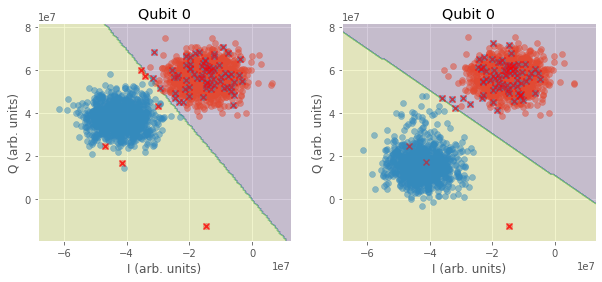

In [ ]:
from qiskit.ignis.measurement.discriminator.iq_discriminators import *

fig, ax = plt.subplots(1, 2, figsize=(10,4))

discs01 = {}
discs01['LDA'] = LinearIQDiscriminator(result, qubit_mask=[0], schedules=['cal_0', 'cal_1'])
discs01['LDA'].plot(ax[0], show_boundary=True, flag_misclassified=True)

discs02 = {}
discs02['LDA'] = LinearIQDiscriminator(result, qubit_mask=[0], schedules=['cal_0', 'cal_2'], expected_states=['0', '2'])
discs02['LDA'].plot(ax[1], show_boundary=True, flag_misclassified=True)

## Quadratic Discriminant Analysis

QDA is a more generalized version of LDA that doesn't assume the covariances of each class are the same. The decision surface is quadratic by default.

(array([<AxesSubplot:title={'center':'Qubit 0'}, xlabel='I (arb. units)', ylabel='Q (arb. units)'>],
       dtype=object),
 None)

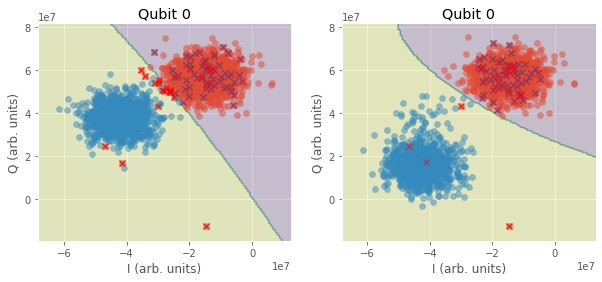

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))

discs01['QDA'] = QuadraticIQDiscriminator(result, qubit_mask=[0], schedules=['cal_0', 'cal_1'], expected_states=['0', '1'])
discs01['QDA'].plot(ax[0], show_boundary=True, flag_misclassified=True)

discs02['QDA'] = QuadraticIQDiscriminator(result, qubit_mask=[0], schedules=['cal_0', 'cal_2'], expected_states=['0', '2'])
discs02['QDA'].plot(ax[1], show_boundary=True, flag_misclassified=True)

## Comparison of classifiers

Let's create a filter for each discriminator that can be used to convert any level 1 data into level 2 data.

In [ ]:
from qiskit.ignis.measurement.discriminator.filters import DiscriminationFilter

filters01 = {}
for key in discs01:
    filters01[key] = DiscriminationFilter(discs01[key],0)
    
filters02 = {}
for key in discs02:
    filters02[key] = DiscriminationFilter(discs02[key],0)

## Visualize 

LDA, 0 and 1 false rate = 0.037109375
LDA, 0 and 2 false rate = 0.05419921875
QDA, 0 and 1 false rate = 0.0400390625
QDA, 0 and 2 false rate = 0.03662109375


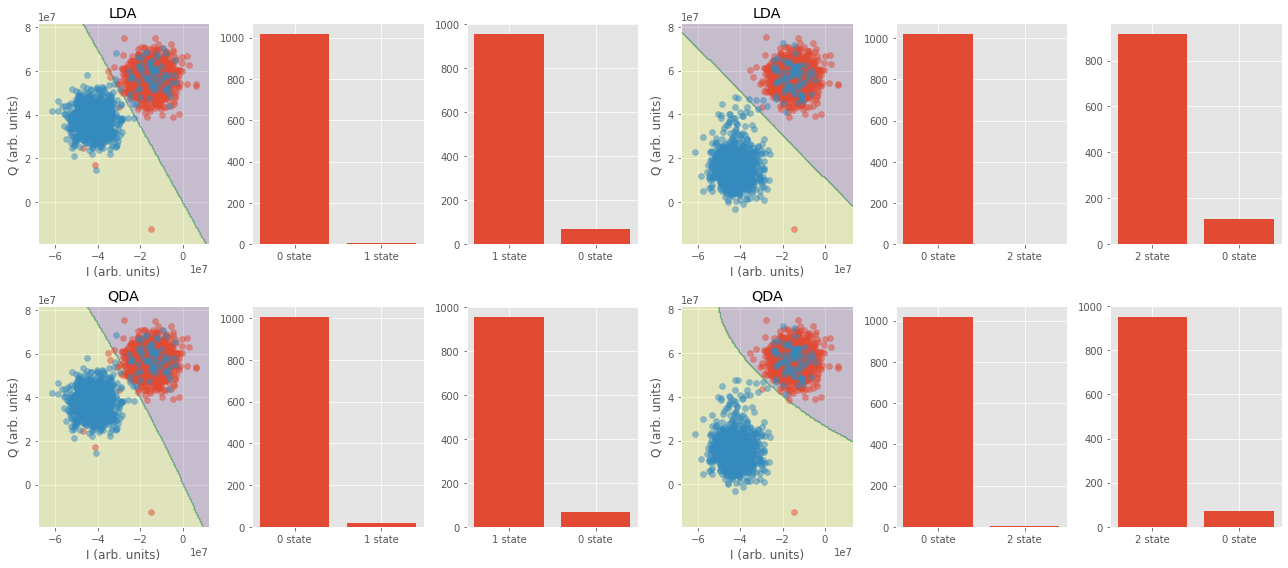

In [ ]:
fig, ax = plt.subplots(2, 6, figsize=(18,8))

for i, c in enumerate(["LDA", "QDA"]):
    discs01[c].plot(ax[i, 0], show_boundary=True)
    ax[i, 0].set_title(c)
    counts = filters01[c].apply(result).get_counts()
    ax[i, 1].bar(["0 state", "1 state"], counts[0].values())
    ax[i, 2].bar(["1 state", "0 state"], counts[1].values())
    print(f"{c}, 0 and 1 false rate = {(min(counts[0].values())+min(counts[1].values()))/2048}")

    discs02[c].plot(ax[i, 3], show_boundary=True)
    ax[i, 3].set_title(c)
    counts = filters02[c].apply(result).get_counts()
    ax[i, 4].bar(["0 state", "2 state"], counts[0].values())
    ax[i, 5].bar(["2 state", "0 state"], counts[1].values())    
    
    print(f"{c}, 0 and 2 false rate = {(min(counts[0].values())+min(counts[1].values()))/2048}")
plt.tight_layout()

## Bonus: Classifying more than two states

We can use LDA and QDA for higher dimensions, or we can try a different classifier.

## Support Vector Classifier (SVC)

SVCs are supervised learning methods that supports high dimensional classification.

(array([<AxesSubplot:title={'center':'Qubit 0'}, xlabel='I (arb. units)', ylabel='Q (arb. units)'>],
       dtype=object),
 <Figure size 432x288 with 1 Axes>)

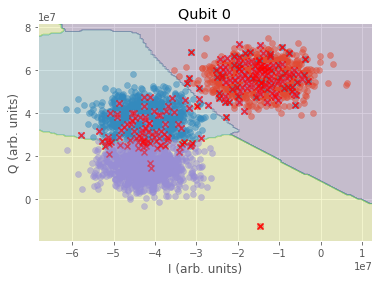

In [ ]:
from sklearn.svm import SVC

svc = SVC(C=1., kernel="rbf", gamma="scale")
discs_012={}
discs_012['SVC'] = SklearnIQDiscriminator(svc, result, qubit_mask=[0], schedules=None, expected_states=['0','1','2'])
discs_012['SVC'].plot(show_boundary=True, flag_misclassified=True)

# 5. Evaluate excited state promoted readout

Now let's do a mock experiment. Using the first half of our results as the training set, we'll train a classifier to distinguish 0 vs 1 or 0 vs 2, then measure the false error rate on the test set and compare doing excited state readout versus normal readout.

In [ ]:
def reshape_complex_vec(vec):
    length = len(vec)
    vec_reshaped = np.zeros((length, 2))
    for i in range(len(vec)):
        vec_reshaped[i]=[np.real(vec[i]), np.imag(vec[i])]
    return vec_reshaped

In [ ]:
from sklearn.model_selection import train_test_split

zero_data_reshaped = reshape_complex_vec(zero_data)
one_data_reshaped = reshape_complex_vec(one_data)  
two_data_reshaped = reshape_complex_vec(two_data)  

classifiers={"LDA": LinearDiscriminantAnalysis(),
             "QDA": QuadraticDiscriminantAnalysis(),
             "SVC": SVC(C=1., kernel="rbf", gamma="scale")}

for type in classifiers:
    IQ_01_data = np.concatenate((zero_data_reshaped, one_data_reshaped))
    state_01 = np.zeros(1024)
    state_01 = np.concatenate((state_01, np.ones(1024)))
    IQ_train, IQ_test, state_train, state_test = train_test_split(IQ_01_data, state_01, test_size=0.5)

    classifiers[type].fit(IQ_train, state_train)
    score = classifiers[type].score(IQ_test, state_test)
    print(f"{type} 0, 1 state discrimination score: {score}")
    
    IQ_02_data = np.concatenate((zero_data_reshaped, two_data_reshaped))
    state_02 = np.zeros(1024)
    state_02 = np.concatenate((state_02, np.ones(1024)))
    IQ_train, IQ_test, state_train, state_test = train_test_split(IQ_02_data, state_02, test_size=0.5)

    
    classifiers[type].fit(IQ_train, state_train)
    score = classifiers[type].score(IQ_test, state_test)
    print(f"{type} 0, 2 state discrimination score: {score}")

LDA 0, 1 state discrimination score: 0.9609375
LDA 0, 2 state discrimination score: 0.9619140625
QDA 0, 1 state discrimination score: 0.958984375
QDA 0, 2 state discrimination score: 0.9638671875
SVC 0, 1 state discrimination score: 0.962890625
SVC 0, 2 state discrimination score: 0.96484375


# Takeaways

- We learned how to calibrate qubit frequencies, Rabi amplitudes, and I-Q discriminators
- Qiskit Pulse is a powerful tool for low-level quantum programming
- Many built-in Qiskit libraries exist for analysis and post-processing

Coming up next: Pulse discussion panel with me, Zach Schoenfeld, and Sadik Hafizovic

Coming up at 15:15 MDT: Breakout session with me and Zach Schoenfeld (ask questions here!)